Load data

In [4931]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

chargingprofile1 = pd.read_csv('./data/yearly_charging_profile_1.csv', header=None)
chargingprofile1 = chargingprofile1.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile1.index = range(1, len(chargingprofile1) + 1)
chargingprofile1 = min_max_normalize(chargingprofile1)

consumer1 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad861.csv', header=None)
consumer1 = consumer1
consumer1.columns = range(1, consumer1.shape[1] + 1)
consumer1.index = range(1, len(consumer1) + 1)

consumer2 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad464.csv', header=None)
consumer2 = consumer2
consumer2.columns = range(1, consumer2.shape[1] + 1)
consumer2.index = range(1, len(consumer2) + 1)

consumer3 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad540.csv', header=None)
consumer3 = consumer3
consumer3.columns = range(1, consumer3.shape[1] + 1)
consumer3.index = range(1, len(consumer3) + 1)

solargen = pd.read_excel('./data/Belgium_solar_generation_probability_density.xlsx', sheet_name='Solar_profiles',header=None)
solargen = solargen
solargen = solargen.drop(index=0, columns=0).reset_index(drop=True)
solargen.index = range(1, len(solargen) + 1)
solargen = solargen.iloc[:, :-1]

Fancharts

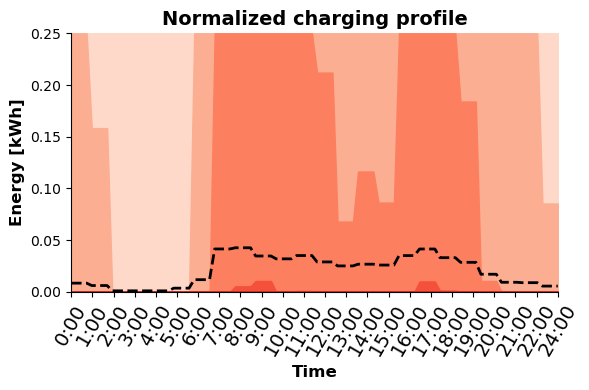

In [4932]:
df = chargingprofile1/4

percentiles = [0,2,10,20,30,40,50,60,70,80,90,98,100]
time_intervals = np.arange(1, 97)  # 96 time intervals for the day

significant_patterns = np.zeros((len(time_intervals), len(percentiles)))
for i,p in enumerate((percentiles)):
    significant_patterns[:, i] = np.percentile(df.values, p, axis=1)

columns_names = [f'pct{p}' for p in percentiles]
percentiles_df = pd.DataFrame(significant_patterns, columns=columns_names)
percentiles_df.insert(0, 'Time', time_intervals)

fig, ax = plt.subplots(figsize=(6, 4))
xs = percentiles_df['Time']
colors = plt.cm.Reds(np.linspace(0.15, 0.85, 6))
# for lower, upper, color in zip([f'pct0.{i}'+'5' for i in range(0, 5)], [f'pct0.{i}'+'5' for i in range(9, 4, -1)], colors):
lowers = columns_names[:6]
uppers = columns_names[7:][::-1]
for lower, upper, color in zip(lowers, uppers, colors):
    ax.fill_between(xs, percentiles_df[lower], percentiles_df[upper], color=color, label=f'{lower}-{upper}')
#ax.plot(xs, percentiles_df['pct50'], color='black', lw=2, label='Median')  # Median
ax.plot(xs, df.mean(axis=1), color='black', lw=2, linestyle='--', label='Mean')  # Mean
ax.set_xticks(np.linspace(1, 96, 24, endpoint=True))  # Set 24-hour labels
ax.set_xticklabels([f'{int(t)}:00' for t in np.linspace(0, 24, 24, endpoint=True)], rotation=60, fontsize=14)
ax.set_xlim(1, 96)
ax.set_ylim(0, np.max(significant_patterns))
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy [kWh]', fontsize=12, fontweight='bold')
ax.set_title('Normalized charging profile', fontsize=14, fontweight='bold')

# Add legend and styling
#ax.legend(loc='upper left', fontsize=10)
ax.margins(x=0)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()
# ax.stairs(np.mean(all_y_values, axis=1), color='black', lw=2, label='Mean', linestyle='--')
# ax.set_xticks(xs)
# ax.set_xticklabels(percentiles_df['Time'].astype(str).apply(lambda x: x[:2]), rotation=45, fontsize=fontsize)
# ax.legend(loc='upper left')
# ax.margins(x=0)
# ax.set_xlim(0,23)
# ax.set_ylim(0, np.max(significant_patterns))
# ax.set_xlabel('Hour', fontsize=fontsize, fontweight='bold')
# ax.set_ylabel('Power [kW]', fontsize=fontsize, fontweight='bold')
# ax.set_title('Number of scenarios: ' + str(n_extractions), fontsize=fontsize, fontweight='bold')
# for sp in ['top', 'right']:
#     ax.spines[sp].set_visible(False)
# plt.tight_layout()
# if savefig_flag:
#     fig.savefig(path_plots + 'scenarios_fanchart.png', dpi=300)

# if not savefig_flag:
#     plt.show()

Compressing over days

In [4933]:
def sum_columns(df):
    # Sum the values of each column and return as a Series
    return df.sum()

KPIs

In [4934]:
def moments(s):
    min_M = s.min()
    max_M = s.max()
    mean_M = s.mean()
    std_M = s.std()
    skew_M = s.skew()
    kurt_M = s.skew()
    return min_M, max_M, mean_M, std_M, skew_M, kurt_M

def quartiles(s):
    q5_M = s.quantile(.05)
    q95_M = s.quantile(0.95)
    return q5_M, q95_M

def min_max_load(M):
    min_M = M.min().min()
    max_M = M.max().max()
    # KPI 3: Total energy consumed​
    sum_M = M.sum().sum()
    
    E = sum_columns(M)
    return min_M, max_M, sum_M

def difference(M):
    diff = M.diff().iloc[1:]
    return diff

def scenarios(baseload_kwh, solargen_kw, chargingprofile_kw):
    baseload_kw = baseload_kwh*4
    pv1 = baseload_kw - solargen_kw
    pv5 = baseload_kw - (5*solargen_kw)
    pv10 = baseload_kw - (10*solargen_kw)
    ev2 = baseload_kw + (2.5*chargingprofile_kw)
    ev7 = baseload_kw + (7*chargingprofile_kw)
    ev11 = baseload_kw + (11*chargingprofile_kw)
    return baseload_kwh, pv1/4, pv5/4, pv10/4, ev2/4, ev7/4, ev11/4

# s = pd.Series(M.values.flatten())

In [4935]:
# Create a heatmap
kwp_set = [0, 1, 5, 10]
kw_set = [0, 2.5, 7, 11]

matrix_min = np.zeros((4, 4))
matrix_max = np.zeros((4, 4))
matrix_mean = np.zeros((4, 4))
matrix_std = np.zeros((4, 4))
matrix_skew = np.zeros((4, 4))
matrix_kurt = np.zeros((4, 4))
matrix_load = np.zeros((4, 4))
matrix_q5 = np.zeros((4, 4))
matrix_q95 = np.zeros((4, 4))

for kwp in range(4):
    for kw in range(4):
        net_load = consumer1*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
        net_load = net_load/4
        net_load = sum_columns(net_load)
        
        matrix_min[kwp,kw] = net_load.values.flatten().min()
        matrix_max[kwp,kw] = net_load.values.flatten().max()
        matrix_mean[kwp,kw] = net_load.values.flatten().mean()
        matrix_std[kwp,kw] = net_load.values.flatten().std()
        matrix_skew[kwp,kw] = pd.Series(net_load.values.flatten()).skew()
        matrix_kurt[kwp,kw] = pd.Series(net_load.values.flatten()).kurt()
        matrix_load[kwp,kw] = net_load.sum().sum()
        matrix_q5[kwp,kw] = pd.Series(net_load.values.flatten()).quantile(.05)
        matrix_q95[kwp,kw] = pd.Series(net_load.values.flatten()).quantile(.95)

def heatmap(matrix, moment):
    matrix = matrix[::-1]
    plt.figure(figsize=(8, 6))
    x_labels = ['0', '2,5', '7', '11']  # X-axis labels
    y_labels = ['10', '5', '1', '0']  # Y-axis labels
    sns.heatmap(matrix, annot=True, cmap='coolwarm', cbar=True,xticklabels=x_labels, yticklabels=y_labels, annot_kws={"size": 12})
    # Add a title and show the plot
    cbar = plt.gca().collections[0].colorbar

# Increase the size of the numbers on the colorbar
    title = (
            f'{moment} [kWh]' if moment == "Mean" or moment == "Standard deviation" or moment == "Minimum" or moment == "Maximum" or moment == "Total energy consumed" or moment == "0,05 quantile" or moment == "0,95 quantile"  else
            moment    )
    cbar.ax.tick_params(labelsize=16)  # Adjust 16 to the desired font size
    plt.title(title, fontsize=18,weight='bold')
    plt.ylabel("PV: kWp values", fontsize=18)
    plt.xlabel("EV: charger kW values", fontsize=18)
    plt.show()



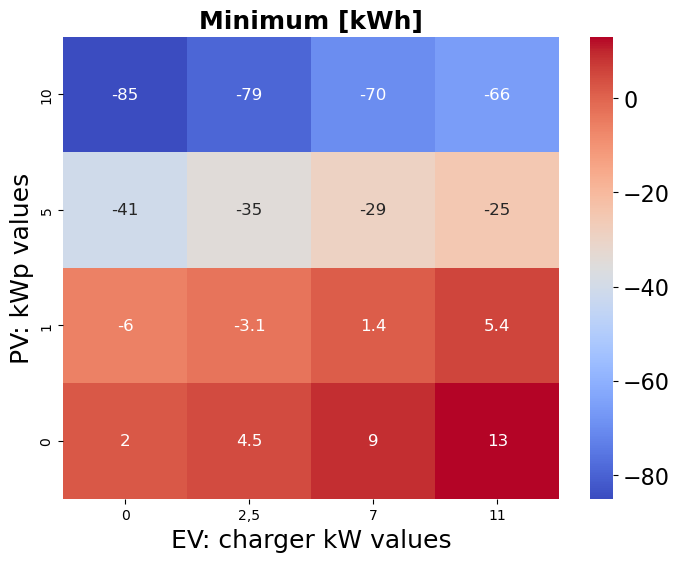

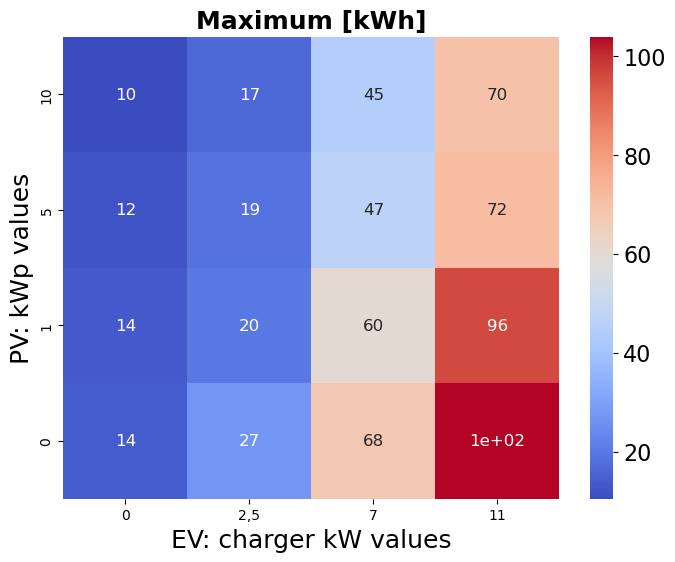

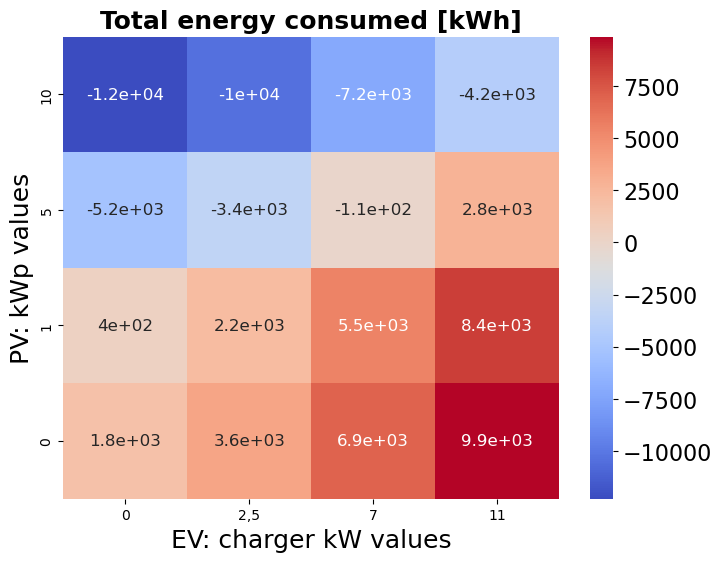

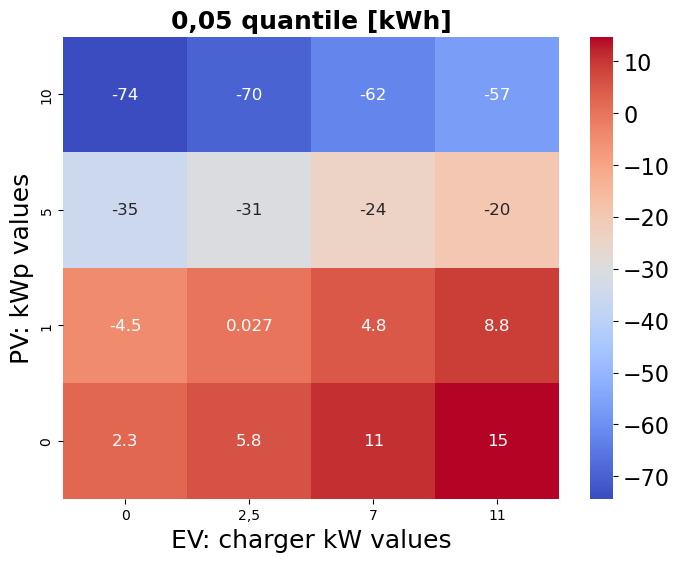

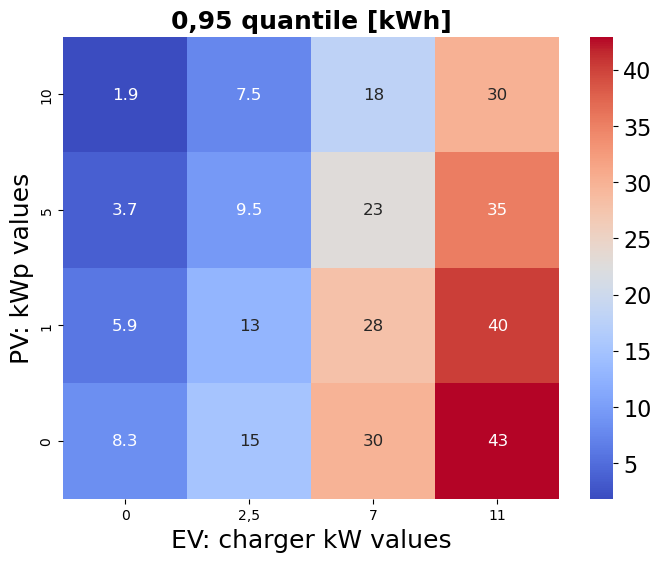

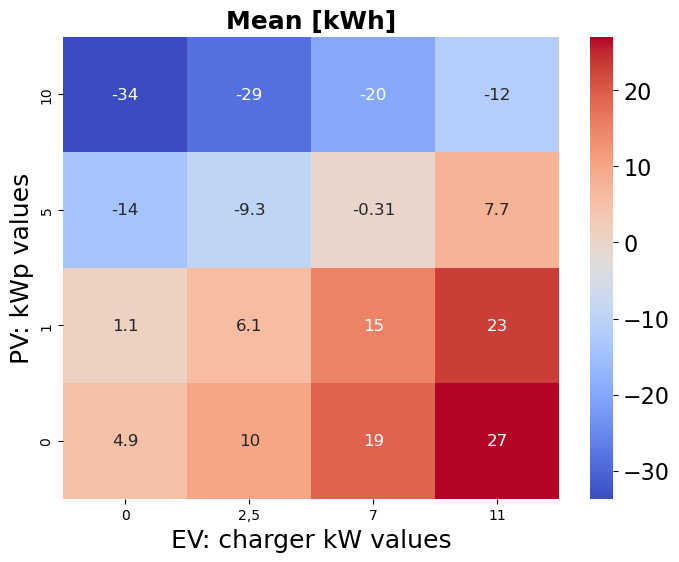

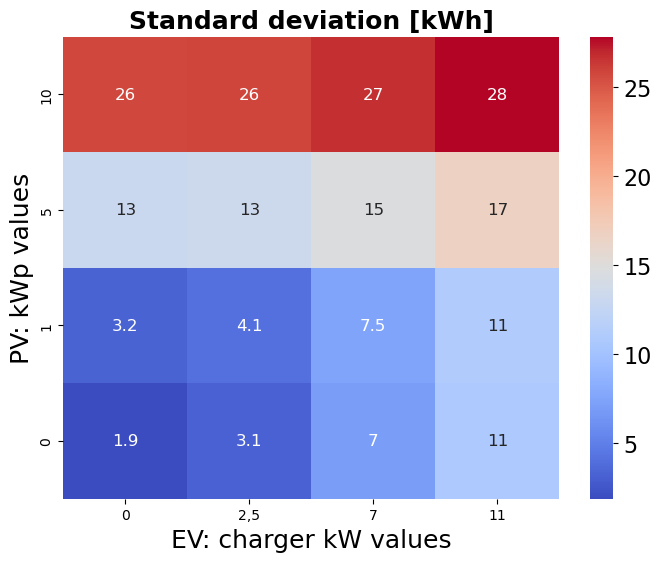

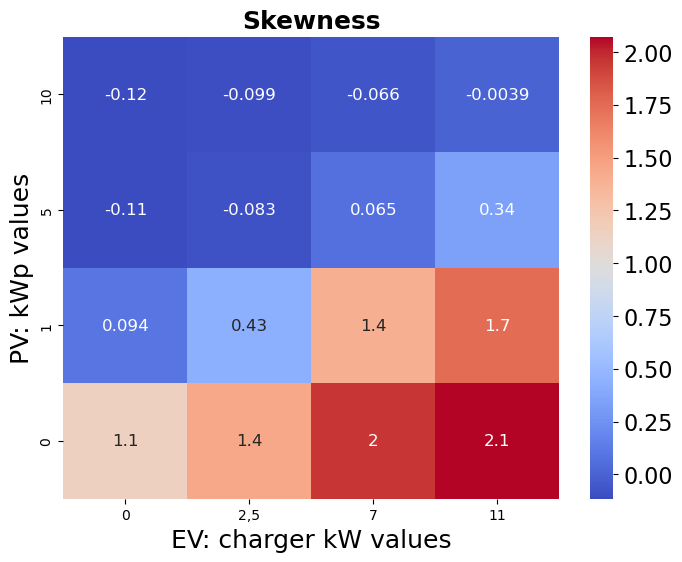

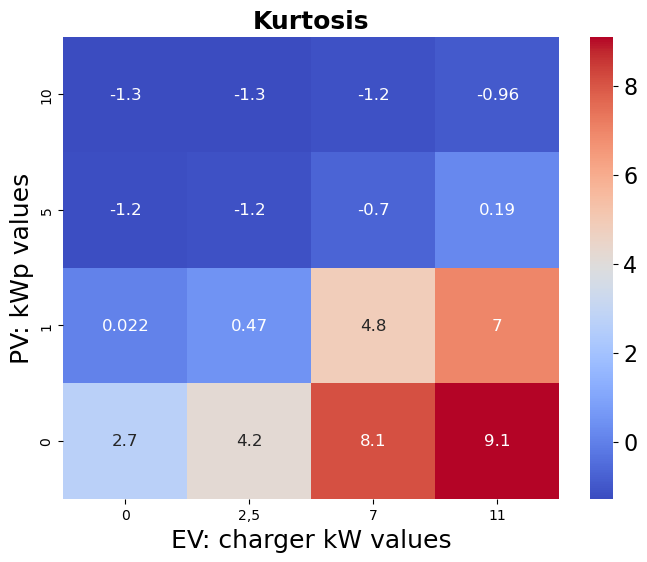

In [4936]:
heatmap(matrix_min, 'Minimum')
heatmap(matrix_max, 'Maximum')
heatmap(matrix_load, 'Total energy consumed')
heatmap(matrix_q5, '0,05 quantile')
heatmap(matrix_q95, '0,95 quantile')
heatmap(matrix_mean, 'Mean')
heatmap(matrix_std, 'Standard deviation')
heatmap(matrix_skew, 'Skewness')
heatmap(matrix_kurt, 'Kurtosis')



In [4937]:
scenarios = scenarios(consumer1, solargen, chargingprofile1)
print(len(scenarios))
row_means = []
for scenario in scenarios:
    scenario_row_means = scenario.std(axis=1)  # Calculate mean across columns for each row (day)
    row_means.append(scenario_row_means)
def plot_boxplots_of_means(row_means):
    # Set up the figure with a large number of subplots (16 boxplots)
    plt.figure(figsize=(18, 10))  # Adjust figure size for 16 boxplots
    sns.set(style="whitegrid")

    # Create one boxplot per scenario
    for i, row_mean in enumerate(row_means):
        plt.subplot(4, 4, i+1)  # 4 rows and 4 columns of subplots, adjust this if needed
        sns.boxplot(data=row_mean)
        plt.title(f"Scenario {i+1}", fontsize=12)
        plt.xlabel('Mean of each row (day)', fontsize=10)
        plt.ylabel('Energy Consumption (kWh)', fontsize=10)

    plt.tight_layout()  # To adjust the subplots and prevent overlap
    plt.show()

#plot_boxplots_of_means(row_means)



7


In [4938]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_all_scenarios_in_one_graph(row_means):
    # Create a list to hold all row means along with their scenario labels
    all_means = []
    scenario_labels = []
    
    # Loop over each scenario and add its row means and corresponding label
    for i, row_mean in enumerate(row_means):
        all_means.extend(row_mean)
        scenario_labels.extend([f"Scenario {i+1}"] * len(row_mean))
    
    # Create the boxplot
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    sns.boxplot(x=scenario_labels, y=all_means)
    
    plt.title("Distribution of Daily Mean Energy Consumption Across Scenarios", fontsize=16)
    plt.xlabel("Scenarios", fontsize=12)
    plt.ylabel("Energy Consumption (kWh)", fontsize=12)
    
    # Optionally adjust the rotation of x-axis labels if needed
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Example usage
# row_means is a list of series, where each series corresponds to the row-wise means of a scenario
#plot_all_scenarios_in_one_graph(row_means)


In [4939]:
# kwp_set = [0, 1, 5, 10] 
# kw_set = [0, 2.5, 7, 11]  

# # Create a figure with a 4x4 grid of subplots
# fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)

# # Loop through KWP and KW to calculate net load and plot boxplots
# for i, kwp in enumerate(reversed(range(4))): 
#     for j, kw in enumerate(range(4)):
#         # Calculate net load for this combination
#         net_load1 = consumer1*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
#         net_load1 = net_load1/4
#         net_load2 = consumer2*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
#         net_load2 = net_load2/4
#         net_load3 = consumer3*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
#         net_load3 = net_load3/4

#         min_values1 = []
#         min_values2 = []
#         min_values3 = []

#         max_values1 = []
#         max_values2 = []
#         max_values3 = []

#         mean_values1 = []
#         mean_values2 = []
#         mean_values3 = []

#         std_values1 = []
#         std_values2 = []
#         std_values3 = []

#         skew_values1 = []
#         skew_values2 = []
#         skew_values3 = []

#         kurt_values1 = []
#         kurt_values2 = []
#         kurt_values3 = []

#         for t in range(96):
#             min_values1.append(net_load1.iloc[t].min())
#             min_values2.append(net_load2.iloc[t].min())
#             min_values3.append(net_load3.iloc[t].min())

#             max_values1.append(net_load1.iloc[t].max())
#             max_values2.append(net_load2.iloc[t].max())
#             max_values3.append(net_load3.iloc[t].max())

#             mean_values1.append(net_load1.iloc[t].mean())
#             mean_values2.append(net_load2.iloc[t].mean())
#             mean_values3.append(net_load3.iloc[t].mean())

#             std_values1.append(net_load1.iloc[t].std())
#             std_values2.append(net_load2.iloc[t].std())
#             std_values3.append(net_load3.iloc[t].std())

#             skew_values1.append(net_load1.iloc[t].skew())
#             skew_values2.append(net_load2.iloc[t].skew())
#             skew_values3.append(net_load3.iloc[t].skew())

#             kurt_values1.append(net_load1.iloc[t].kurt())
#             kurt_values2.append(net_load2.iloc[t].kurt())
#             kurt_values3.append(net_load3.iloc[t].kurt())



#         # Plot the boxplot in the corresponding subplot
#         ax = axes[i, j]
#         title = "Kurtosis"
#         # sns.boxplot(x=moment, ax=ax, color="lightblue")
#         # ax.boxplot(min_values1, positions=[1], widths=0.4, patch_artist=True, boxprops=dict(facecolor="blue", alpha=0.5), showfliers=False)
#         # ax.boxplot(min_values2, positions=[1], widths=0.3, patch_artist=True, boxprops=dict(facecolor="red", alpha=0.5), showfliers=False)
#         # ax.boxplot(min_values3, positions=[1], widths=0.2, patch_artist=True, boxprops=dict(facecolor="green", alpha=0.5), showfliers=False)
#         # ax.boxplot([min_values1, min_values2, min_values3], positions=[1, 2, 3], widths=0.4, patch_artist=True,
#         #            boxprops=dict(facecolor="blue", alpha=0.5), showfliers=False)

#         data1=kurt_values1
#         data2=kurt_values2
#         data3=kurt_values3

#         # Create boxplots for three datasets, each with a different color
#         box1 = ax.boxplot([data1, data2, data3], positions=[1, 2, 3], widths=0.4, patch_artist=True, medianprops=dict(color="black"),
#                           showfliers=False)

#         # Customizing colors for each dataset
#         colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
        
#         for patch, color in zip(box1['boxes'], colors):
#             patch.set_facecolor(color)
#             patch.set_edgecolor('black')  # Optional, to outline the box
    

#         # Set titles only for the bottom row and the leftmost column
#         if i == 3:  # Bottom row
#             ax.set_xlabel(f"KW={kw_set[kw]}", fontsize=16)
#         else:
#             ax.set_xlabel("")
        
#         if j == 0:  # Leftmost column
#             ax.set_ylabel(f"KWP={kwp_set[kwp]}", fontsize=16)
#         else:
#             ax.set_ylabel("")
#         # ax.set_title(f"KWP={kwp_set[kwp]}, KW={kw_set[kw]}", fontsize=10)
#         # ax.set_xlabel("")
#         # ax.set_ylabel("")
#         #ax.tick_params(axis='x', labelsize=8)
#         ax.set_xticklabels([])
#         ax.tick_params(axis='y', labelsize=16)
# handles = [
#     plt.Line2D([0], [0], color='#1f77b4', lw=4, label='Consumer 1'),
#     plt.Line2D([0], [0], color='#ff7f0e', lw=4, label='Consumer 2'),
#     plt.Line2D([0], [0], color='#2ca02c', lw=4, label='Consumer 3')
# ]
# fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=12)

# # Set a common title and adjust layout
# fig.suptitle(f"Distribution of {title} Across Time Intervals", fontsize=16)
# # fig.tight_layout(rect=[0, 0, 1, 0.96])
# plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])


# # Show the plot
# plt.show()


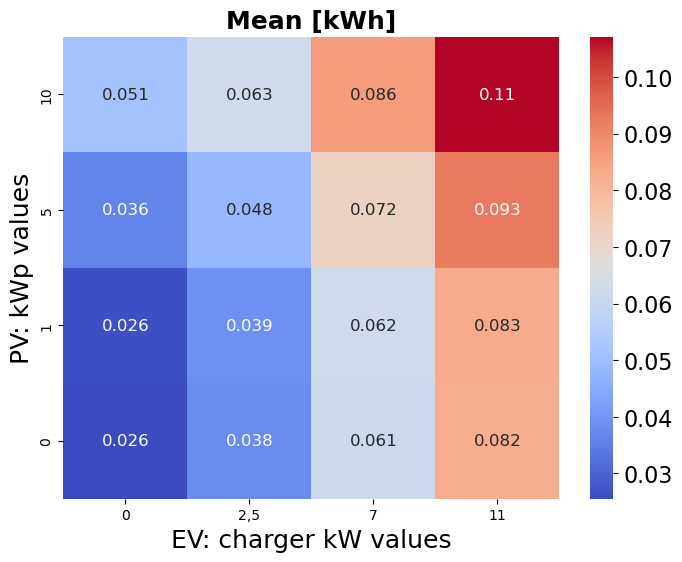

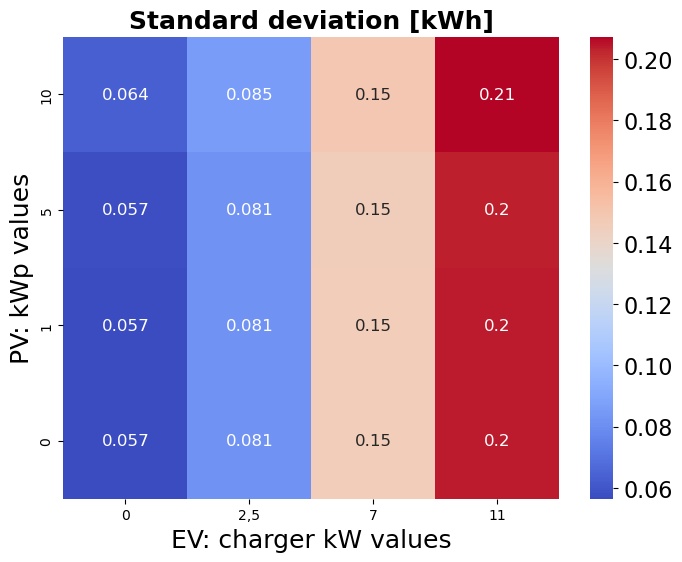

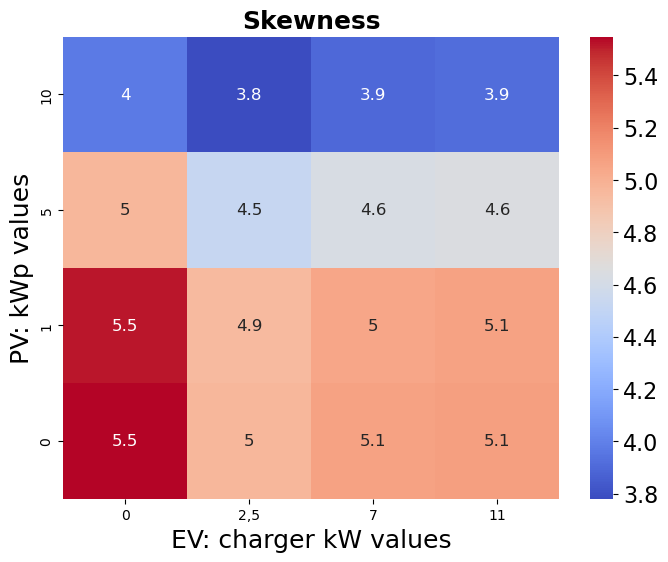

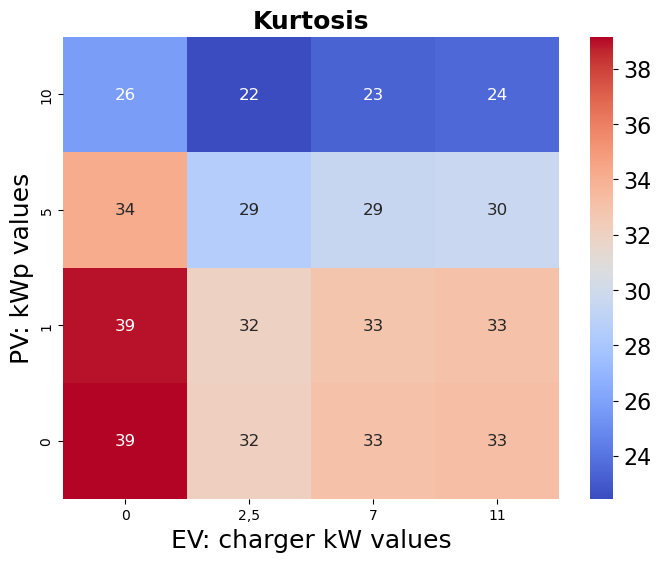

In [4940]:
# Create a heatmap
kwp_set = [0, 1, 5, 10]
kw_set = [0, 2.5, 7, 11]

matrix_min = np.zeros((4, 4))
matrix_max = np.zeros((4, 4))
matrix_mean = np.zeros((4, 4))
matrix_std = np.zeros((4, 4))
matrix_skew = np.zeros((4, 4))
matrix_kurt = np.zeros((4, 4))
matrix_load = np.zeros((4, 4))
matrix_q5 = np.zeros((4, 4))
matrix_q95 = np.zeros((4, 4))

for kwp in range(4):
    for kw in range(4):
        net_load = consumer1*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
        net_load = net_load/4
        net_load = difference(net_load)
        net_load = abs(net_load)

        min = []
        max = []
        mean= []
        std = []
        skew = []
        kurt = []

        for t in range(95):
            min.append(net_load.iloc[t].min())
            max.append(net_load.iloc[t].max())
            mean.append(net_load.iloc[t].mean())
            std.append(net_load.iloc[t].std())
            skew.append(net_load.iloc[t].skew())
            kurt.append(net_load.iloc[t].kurt())

        # matrix_min[kwp,kw] = pd.Series(min).median()
        # matrix_max[kwp,kw] = pd.Series(max).median()
        # matrix_mean[kwp,kw] = pd.Series(mean).median()
        # matrix_std[kwp,kw] = pd.Series(std).median()
        # matrix_skew[kwp,kw] = pd.Series(skew).median()
        # matrix_kurt[kwp,kw] = pd.Series(kurt).median()


        matrix_min[kwp,kw] = pd.Series(min).mean()
        matrix_max[kwp,kw] = pd.Series(max).mean()
        matrix_mean[kwp,kw] = pd.Series(mean).mean()
        matrix_std[kwp,kw] = pd.Series(std).mean()
        matrix_skew[kwp,kw] = pd.Series(skew).mean()
        matrix_kurt[kwp,kw] = pd.Series(kurt).mean()

heatmap(matrix_mean,"Mean")
heatmap(matrix_std, "Standard deviation")
heatmap(matrix_skew, "Skewness")
heatmap(matrix_kurt, "Kurtosis")

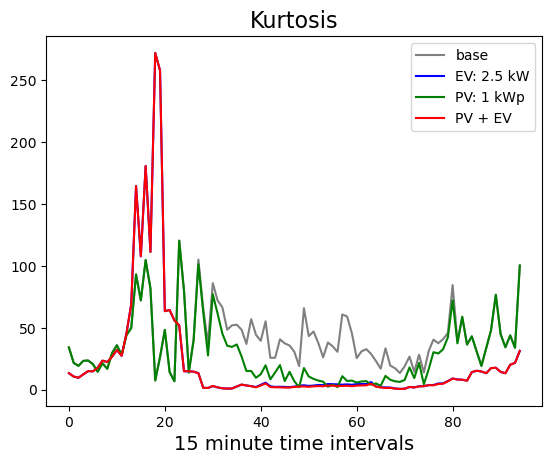

In [4941]:
def plot(metric, title,unit):
            
    label = [
        'base' if kw == 0 and kwp == 0 else
        f'PV: {kwp_set[kwp]} kWp' if kw == 0 and kwp != 0 else
        f'EV: {kw_set[kw]} kW' if kw != 0 and kwp == 0 else
        f'PV + EV'    ]
    plt.plot(metric, color=color[0], label=label[0])
    plt.title(title, fontsize=16)
    plt.xlabel("15 minute time intervals", fontsize=14)
    plt.ylabel(unit,fontsize=14)
    plt.legend()
    s = (
        "base" if kw == 0 and kwp == 0 else
        f"kWp: {kwp_set[kwp]}" if kw == 0 and kwp != 0 else
        f"kW: {kw_set[kw]}" if kw != 0 and kwp == 0 else
        f"kWp: {kwp_set[kwp]}, kW: {kw_set[kw]}")
    
    # plt.text(
    #     x=len(metric) - len(metric)/2,  # Position near the end of the line
    #     y = metric[int(len(metric)/2)],  # Last value of the line
    #     s=s,  # Label
    #     fontsize=10,
    #     color=color[0],
    # )

for kwp in range(2):
    for kw in range(2):
        min = []
        max = []
        mean= []
        std = []
        skew = []
        kurt = []
        net_load = consumer1*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
        net_load = net_load/4
        # net_load=difference(net_load)
        # net_load = abs(net_load)
        for t in range(95):
            min.append(net_load.iloc[t].min())
            max.append(net_load.iloc[t].max())
            mean.append(net_load.iloc[t].mean())
            std.append(net_load.iloc[t].std())
            skew.append(net_load.iloc[t].skew())
            kurt.append(net_load.iloc[t].kurt())
        color = [
            'grey' if kw == 0 and kwp == 0 else
            'green' if kw == 0 and kwp != 0 else
            'blue' if kw != 0 and kwp == 0 else
            'red'    ]

        
        #plot(mean, "Mean", "kWh")
        #plot(mean, "Mean", "kWh")
        plot(kurt, "Kurtosis", "")



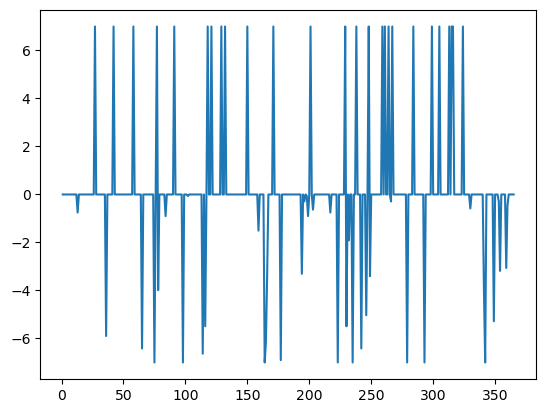

In [4942]:
diff = difference(consumer1+chargingprofile1*7)
# plt.plot(diff[40])
# plt.plot(diff[41])
# plt.plot(diff[42])
# plt.plot(diff[43])
# plt.plot(diff[44])
# plt.plot(diff[45])
# plt.plot(diff[46])
# plt.plot(diff[47])
#plt.plot(diff.iloc[43])
plt.plot((chargingprofile1*7).iloc[44]-(chargingprofile1*7).iloc[43])


In [4943]:
# Create a heatmap
kwp_set = [0, 1, 5, 10]
kw_set = [0, 2.5, 7, 11]

matrix_min = np.zeros((4, 4))
matrix_max = np.zeros((4, 4))
matrix_mean = np.zeros((4, 4))
matrix_std = np.zeros((4, 4))
matrix_skew = np.zeros((4, 4))
matrix_kurt = np.zeros((4, 4))
matrix_load = np.zeros((4, 4))
matrix_q5 = np.zeros((4, 4))
matrix_q95 = np.zeros((4, 4))

for kwp in range(4):
    for kw in range(4):
        net_load = consumer1*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
        net_load = net_load/4
        net_load = difference(net_load)
        net_load = abs(net_load)

        min = []
        max = []
        mean= []
        std = []
        skew = []
        kurt = []

        for t in range(95):
            min.append(net_load.iloc[t].min())
            max.append(net_load.iloc[t].max())
            mean.append(net_load.iloc[t].mean())
            std.append(net_load.iloc[t].std())
            skew.append(net_load.iloc[t].skew())
            kurt.append(net_load.iloc[t].kurt())

        matrix_min[kwp,kw] = pd.series
        matrix_max[kwp,kw] = net_load.values.flatten().max()
        matrix_mean[kwp,kw] = net_load.values.flatten().mean()
        matrix_std[kwp,kw] = net_load.values.flatten().std()
        matrix_skew[kwp,kw] = pd.Series(net_load.values.flatten()).skew()
        matrix_kurt[kwp,kw] = pd.Series(net_load.values.flatten()).kurt()
        matrix_load[kwp,kw] = net_load.sum().sum()
        matrix_q5[kwp,kw] = pd.Series(net_load.values.flatten()).quantile(.05)
        matrix_q95[kwp,kw] = pd.Series(net_load.values.flatten()).quantile(.95)

heatmap(matrix_min,"Minimum")
heatmap(matrix_max,"Maximum")

heatmap(matrix_mean,"Mean")
heatmap(matrix_std,"Standard deviation")
heatmap(matrix_skew,"Skewness")
heatmap(matrix_kurt,"Kurtosis")

AttributeError: module 'pandas' has no attribute 'series'

4.196
5.928


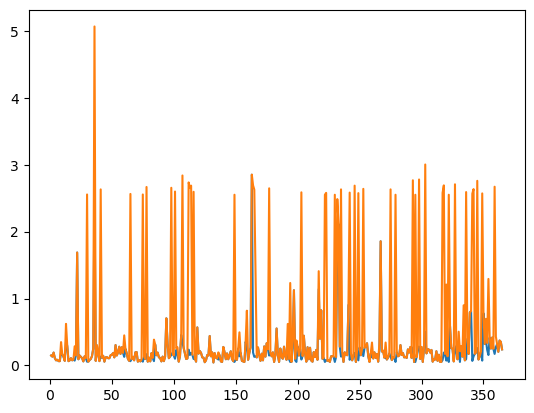

In [ ]:
net_load = 4*consumer1 + 2.5*chargingprofile1
plt.plot((consumer1*4).iloc[40])
plt.plot(net_load.iloc[40])
print(consumer1.max().max()*4)
print(net_load.max().max())



In [ ]:
# kwp_set = [0, 1, 5, 10] 
# kw_set = [0, 2.5, 7, 11]  

# # Create a figure with a 4x4 grid of subplots
# fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)

# # Loop through KWP and KW to calculate net load and plot boxplots
# for i, kwp in enumerate(reversed(range(4))): 
#     for j, kw in enumerate(range(4)):
#         # Calculate net load for this combination
#         net_load1 = consumer1*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
#         net_load1 = difference(net_load1/4)
#         net_load2 = consumer2*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
#         net_load2 = difference(net_load2/4)
#         net_load3 = consumer3*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
#         net_load3 = difference(net_load3/4)

#         min_values1 = []
#         min_values2 = []
#         min_values3 = []

#         max_values1 = []
#         max_values2 = []
#         max_values3 = []

#         mean_values1 = []
#         mean_values2 = []
#         mean_values3 = []

#         std_values1 = []
#         std_values2 = []
#         std_values3 = []

#         skew_values1 = []
#         skew_values2 = []
#         skew_values3 = []

#         kurt_values1 = []
#         kurt_values2 = []
#         kurt_values3 = []

#         for t in range(95):
#             min_values1.append(abs(net_load1.iloc[t]).min())
#             min_values2.append(abs(net_load2.iloc[t]).min())
#             min_values3.append(abs(net_load3.iloc[t]).min())

#             max_values1.append(abs(net_load1.iloc[t]).max())
#             max_values2.append(abs(net_load2.iloc[t]).max())
#             max_values3.append(abs(net_load3.iloc[t]).max())

#             mean_values1.append(abs(net_load1.iloc[t]).mean())
#             mean_values2.append(abs(net_load2.iloc[t]).mean())
#             mean_values3.append(abs(net_load3.iloc[t]).mean())

#             std_values1.append(abs(net_load1.iloc[t]).std())
#             std_values2.append(abs(net_load2.iloc[t]).std())
#             std_values3.append(abs(net_load3.iloc[t]).std())

#             skew_values1.append(abs(net_load1.iloc[t]).skew())
#             skew_values2.append(abs(net_load2.iloc[t]).skew())
#             skew_values3.append(abs(net_load3.iloc[t]).skew())

#             kurt_values1.append(abs(net_load1.iloc[t]).kurt())
#             kurt_values2.append(abs(net_load2.iloc[t]).kurt())
#             kurt_values3.append(abs(net_load3.iloc[t]).kurt())

#         # Plot the boxplot in the corresponding subplot
#         ax = axes[i, j]
#         title = "Kurtosis"
#         # sns.boxplot(x=moment, ax=ax, color="lightblue")
#         # ax.boxplot(min_values1, positions=[1], widths=0.4, patch_artist=True, boxprops=dict(facecolor="blue", alpha=0.5), showfliers=False)
#         # ax.boxplot(min_values2, positions=[1], widths=0.3, patch_artist=True, boxprops=dict(facecolor="red", alpha=0.5), showfliers=False)
#         # ax.boxplot(min_values3, positions=[1], widths=0.2, patch_artist=True, boxprops=dict(facecolor="green", alpha=0.5), showfliers=False)
#         # ax.boxplot([min_values1, min_values2, min_values3], positions=[1, 2, 3], widths=0.4, patch_artist=True,
#         #            boxprops=dict(facecolor="blue", alpha=0.5), showfliers=False)

#         data1=kurt_values1
#         data2=kurt_values2
#         data3=kurt_values3

#         # Create boxplots for three datasets, each with a different color
#         box1 = ax.boxplot([data1, data2, data3], positions=[1, 2, 3], widths=0.4, patch_artist=True, medianprops=dict(color="black"),
#                           showfliers=False)

#         # Customizing colors for each dataset
#         colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
        
#         for patch, color in zip(box1['boxes'], colors):
#             patch.set_facecolor(color)
#             patch.set_edgecolor('black')  # Optional, to outline the box
    

#         # Set titles only for the bottom row and the leftmost column
#         if i == 3:  # Bottom row
#             ax.set_xlabel(f"KW={kw_set[kw]}", fontsize=16)
#         else:
#             ax.set_xlabel("")
        
#         if j == 0:  # Leftmost column
#             ax.set_ylabel(f"KWP={kwp_set[kwp]}", fontsize=16)
#         else:
#             ax.set_ylabel("")
#         # ax.set_title(f"KWP={kwp_set[kwp]}, KW={kw_set[kw]}", fontsize=10)
#         # ax.set_xlabel("")
#         # ax.set_ylabel("")
#         #ax.tick_params(axis='x', labelsize=8)
#         ax.set_xticklabels([])
#         ax.tick_params(axis='y', labelsize=16)
# handles = [
#     plt.Line2D([0], [0], color='#1f77b4', lw=4, label='Consumer 1'),
#     plt.Line2D([0], [0], color='#ff7f0e', lw=4, label='Consumer 2'),
#     plt.Line2D([0], [0], color='#2ca02c', lw=4, label='Consumer 3')
# ]
# fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=12)

# # Set a common title and adjust layout
# fig.suptitle(f"Distribution of {title} Across Time Intervals", fontsize=16)
# # fig.tight_layout(rect=[0, 0, 1, 0.96])
# plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])


# # Show the plot
# plt.show()

